### Bitcoin Prices Scrapping

This notebook is for the 2nd part of Forcasting Course, in which Bitcoin Prices will be scrapped via "Coingecko" api.

In [502]:
# Imports

import requests
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import yfinance as yf
import statsmodels.api as sm

In [503]:
# 🔧 CONFIGURATION (Universal)
TIME_SPAN_DAYS = 364       # Change this to 30, 100, 1000, etc.
INTERVAL = "1d"            # Options: '1d', '1wk', '1mo'

# ✅ ALLOWED INTERVALS and their meanings:
# '1d'   = daily
# '1wk'  = weekly
# '1mo'  = monthly
# Yahoo Finance does NOT support minutely/hourly for BTC

In [504]:
def fetch_btc_data_debug(days=TIME_SPAN_DAYS, interval=INTERVAL):
    end = datetime.today()
    start = end - pd.Timedelta(days=days)
    
    df = yf.download("BTC-USD", start=start, end=end, interval=interval)

    print("\n🧪 Raw Columns:", df.columns)
    print("\n🔍 Sample Data:")
    print(df.head(2))

    return df

In [505]:
raw_df = fetch_btc_data_debug()

[*********************100%***********************]  1 of 1 completed


🧪 Raw Columns: MultiIndex([( 'Close', 'BTC-USD'),
            (  'High', 'BTC-USD'),
            (   'Low', 'BTC-USD'),
            (  'Open', 'BTC-USD'),
            ('Volume', 'BTC-USD')],
           names=['Price', 'Ticker'])

🔍 Sample Data:
Price              Close          High           Low          Open  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2024-05-03  62889.835938  63320.503906  58848.312500  59122.300781   
2024-05-04  63891.472656  64494.957031  62599.351562  62891.031250   

Price            Volume  
Ticker          BTC-USD  
Date                     
2024-05-03  33172023048  
2024-05-04  20620477992  


In [506]:
def fetch_btc_data(days=TIME_SPAN_DAYS, interval=INTERVAL):
    """
    Fetch BTC-USD from Yahoo Finance with MultiIndex flattening.
    Returns: DataFrame with 'timestamp' and 'price'
    """
    end = datetime.today()
    start = end - pd.Timedelta(days=days)

    df = yf.download("BTC-USD", start=start, end=end, interval=interval)

    if df.empty:
        print("❌ No data returned.")
        return pd.DataFrame()

    # ✅ Flatten MultiIndex (Price, Ticker) → "Close BTC-USD"
    df.columns = [' '.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]

    # ✅ Reset index to access 'Date'
    df = df.reset_index()

    # ✅ Rename columns
    if "Date" in df.columns and "Close BTC-USD" in df.columns:
        df = df.rename(columns={"Date": "timestamp", "Close BTC-USD": "price"})
    else:
        print("❌ Columns not found after flattening.")
        return pd.DataFrame()

    # ✅ Clean up
    df["price"] = pd.to_numeric(df["price"], errors="coerce")
    df = df.dropna(subset=["price", "timestamp"])

    print(f"✅ Cleaned data shape: {df.shape} | Interval: {interval} | Days: {days}")
    return df

In [507]:
btc_df = fetch_btc_data()
btc_df.head()

[*********************100%***********************]  1 of 1 completed

✅ Cleaned data shape: (365, 6) | Interval: 1d | Days: 364


,timestamp,price,High BTC-USD,Low BTC-USD,Open BTC-USD,Volume BTC-USD
0,2024-05-03,62889.835938,63320.503906,58848.312500,59122.300781,33172023048
1,2024-05-04,63891.472656,64494.957031,62599.351562,62891.031250,20620477992
2,2024-05-05,64031.132812,64610.890625,62955.304688,63892.453125,18296164805
3,2024-05-06,63161.949219,65494.902344,62746.238281,64038.312500,28697928697
4,2024-05-07,62334.816406,64390.457031,62285.980469,63162.761719,25930730982


In [508]:
btc_df.describe()

,timestamp,price,High BTC-USD,Low BTC-USD,Open BTC-USD,Volume BTC-USD
count,365,365.000000,365.000000,365.000000,365.000000,3.650000e+02
mean,2024-11-01 00:00:00,77714.610381,79147.107288,76110.300310,77610.595826,4.000047e+10
min,2024-05-03 00:00:00,53948.753906,54838.144531,49121.238281,53949.085938,9.858199e+09
25%,2024-08-02 00:00:00,63192.976562,64489.707031,62440.726562,63173.351562,2.560481e+10
50%,2024-11-01 00:00:00,70757.164062,71907.851562,69322.031250,70568.351562,3.287589e+10
75%,2025-01-31 00:00:00,94488.437500,95598.492188,92525.843750,94416.289062,4.718069e+10
max,2025-05-02 00:00:00,106146.265625,109114.882812,105291.734375,106147.296875,1.492189e+11
std,NaN,15789.659063,16085.291684,15429.247297,15787.081529,2.357139e+10


In [509]:
btc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   timestamp       365 non-null    datetime64[ns]
 1   price           365 non-null    float64       
 2   High BTC-USD    365 non-null    float64       
 3   Low BTC-USD     365 non-null    float64       
 4   Open BTC-USD    365 non-null    float64       
 5   Volume BTC-USD  365 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 17.2 KB


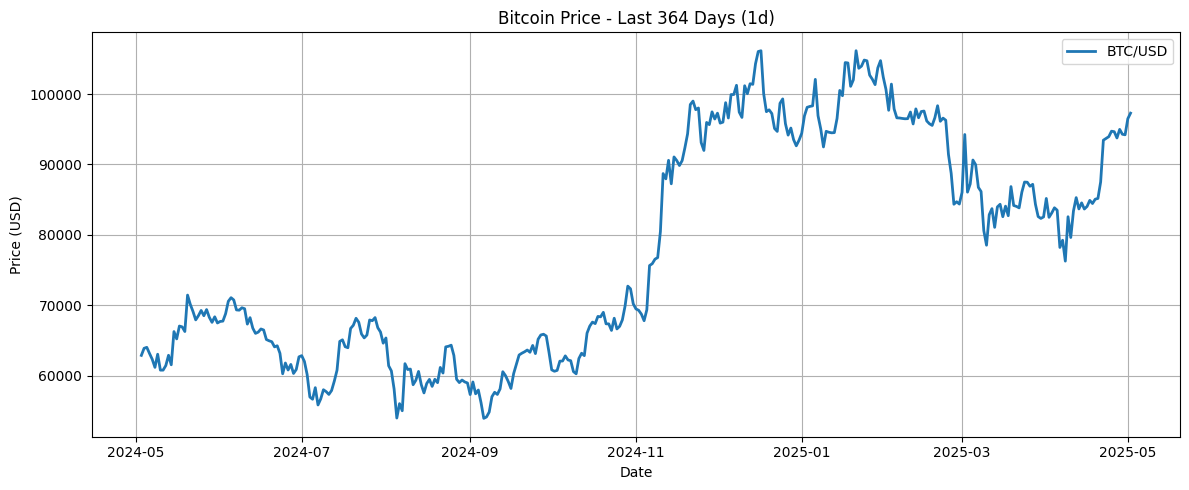

📊 Summary from 2024-05-03 to 2025-05-02:
- Min price:  $53,948.75
- Max price:  $106,146.27
- Mean price: $77,714.61


In [510]:
def plot_btc_price(df, title=None):
    """
    Plot BTC price over time and print summary stats.
    """
    if df.empty:
        print("No data to plot.")
        return

    if title is None:
        title = f"Bitcoin Price - Last {TIME_SPAN_DAYS} Days ({INTERVAL})"

    plt.figure(figsize=(12, 5))
    plt.plot(df["timestamp"], df["price"], label="BTC/USD", linewidth=2)
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Text summary
    print(f"📊 Summary from {df['timestamp'].iloc[0].date()} to {df['timestamp'].iloc[-1].date()}:")
    print(f"- Min price:  ${df['price'].min():,.2f}")
    print(f"- Max price:  ${df['price'].max():,.2f}")
    print(f"- Mean price: ${df['price'].mean():,.2f}")


plot_btc_price(btc_df)



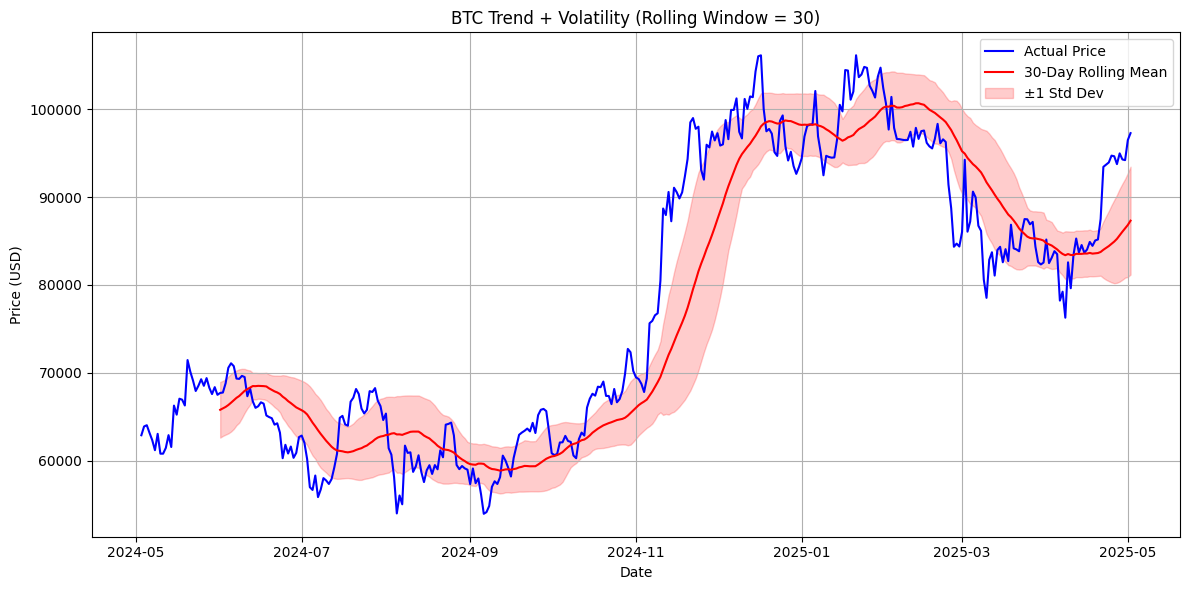

📈 Interpretation:
- Red line = smoothed trend
- Shaded area = volatility (price uncertainty)
- Window size = 30 days


In [511]:
def plot_rolling_stats(df, window=30):
    """
    Plot rolling mean and ±1 std dev for BTC price.
    """
    if df.empty:
        print("No data for rolling analysis.")
        return

    rolling_mean = df["price"].rolling(window=window).mean()
    rolling_std = df["price"].rolling(window=window).std()

    plt.figure(figsize=(12, 6))
    plt.plot(df["timestamp"], df["price"], label="Actual Price", color='blue')
    plt.plot(df["timestamp"], rolling_mean, label=f"{window}-Day Rolling Mean", color='red')
    plt.fill_between(df["timestamp"],
                     rolling_mean - rolling_std,
                     rolling_mean + rolling_std,
                     color='red', alpha=0.2, label="±1 Std Dev")
    plt.title(f"BTC Trend + Volatility (Rolling Window = {window})")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("📈 Interpretation:")
    print("- Red line = smoothed trend")
    print("- Shaded area = volatility (price uncertainty)")
    print(f"- Window size = {window} days")


plot_rolling_stats(btc_df, window=30)

In [512]:
def adf_test(df):
    """
    Perform Augmented Dickey-Fuller test on BTC price series.
    """
    if df.empty or df["price"].isnull().all():
        print("❌ No data available for ADF test.")
        return

    result = adfuller(df["price"].dropna())
    print("🔍 Augmented Dickey-Fuller Test:")
    print(f"- ADF Statistic: {result[0]:.4f}")
    print(f"- p-value: {result[1]:.4f}")
    for key, value in result[4].items():
        print(f"- Critical Value ({key}): {value:.4f}")

    if result[1] < 0.05:
        print("✅ Conclusion: Series is likely STATIONARY.")
    else:
        print("❌ Conclusion: Series is likely NON-STATIONARY (needs differencing or transformation).")


adf_test(btc_df)


🔍 Augmented Dickey-Fuller Test:
- ADF Statistic: -1.1184
- p-value: 0.7077
- Critical Value (1%): -3.4484
- Critical Value (5%): -2.8695
- Critical Value (10%): -2.5710
❌ Conclusion: Series is likely NON-STATIONARY (needs differencing or transformation).


<Figure size 1200x400 with 0 Axes>

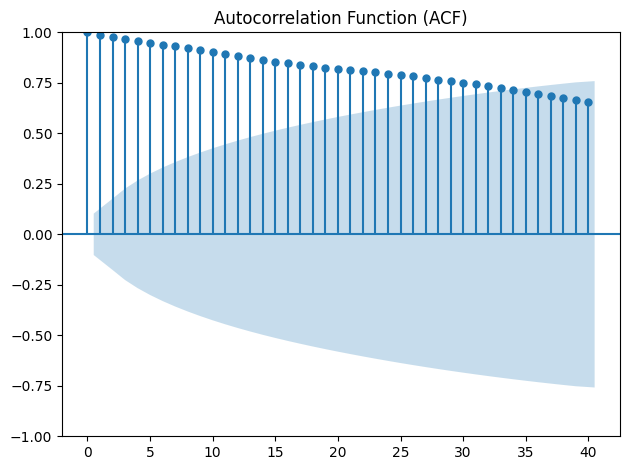

<Figure size 1200x400 with 0 Axes>

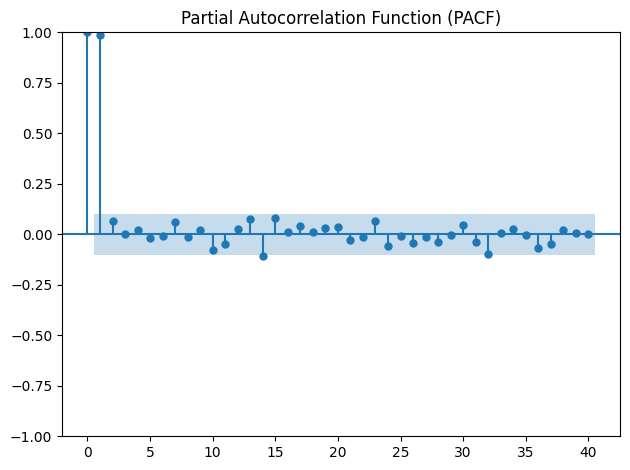

🧠 Interpretation:
- ACF cuts off, PACF tails off: → MA model
- PACF cuts off, ACF tails off: → AR model
- Both tail off: → ARMA/ARIMA model likely


In [513]:
def plot_acf_pacf(df, lags=40):
    """
    Plot ACF and PACF for BTC price.
    """
    if df.empty or df["price"].isnull().all():
        print("No data available for ACF/PACF.")
        return

    values = df["price"].dropna()

    plt.figure(figsize=(12, 4))
    plot_acf(values, lags=lags)
    plt.title("Autocorrelation Function (ACF)")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 4))
    plot_pacf(values, lags=lags, method='ywm')
    plt.title("Partial Autocorrelation Function (PACF)")
    plt.tight_layout()
    plt.show()

    print("🧠 Interpretation:")
    print("- ACF cuts off, PACF tails off: → MA model")
    print("- PACF cuts off, ACF tails off: → AR model")
    print("- Both tail off: → ARMA/ARIMA model likely")



plot_acf_pacf(btc_df, lags=40)